1# The following function calculates the thrust coefficient (CT) for each beam element in an array (a) representing the axial induction factor for every element, considering Glauert correction for a heavily loaded rotor.

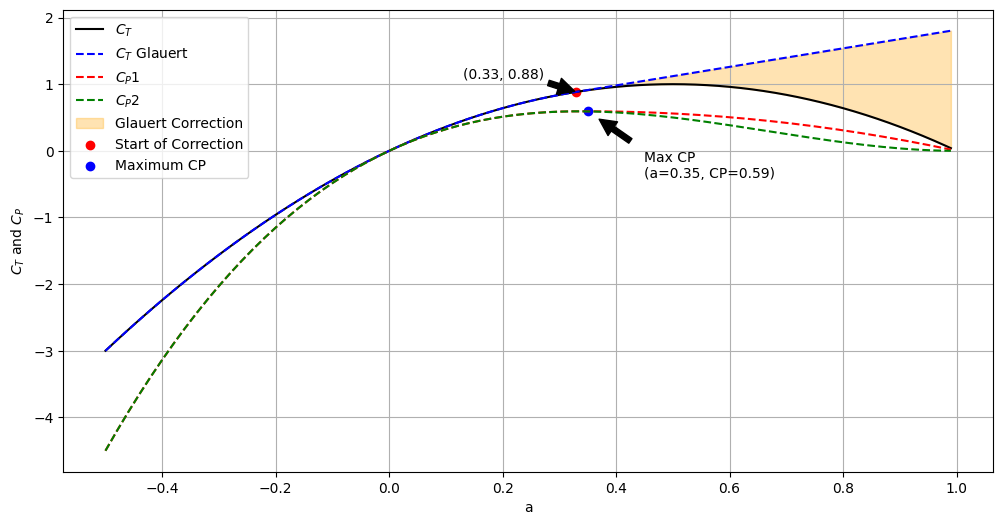

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def CTfunction(a, glauert=False):
    """
    Calculate the thrust coefficient as a function of induction factor 'a'.
    """
    CT = np.zeros_like(a)  # Initialize array for thrust coefficient

    # Calculate the thrust coefficient using the original formula with no corrections yet.
    CT = 4 * a * (1 - a) # Valide for Light loaded rotor, where a < (1-(√(CT1)/2)); where CT1=1.816

    # Apply Glauert's correction if specified
    if glauert:
        CT1 = 1.816
        a1 = 1 - np.sqrt(CT1) / 2 #threshold criterion
        CT[a > a1] = CT1 - 4 * (np.sqrt(CT1) - 1) * (1 - a[a > a1]) # Applying Glauert's correction for the zone of a > a1; where a1 = (1-(√(CT1)/2))

    return CT

def ainduction(CT):
    """
    Calculate the induction factor 'a' as a function of thrust coefficient 'CT' including Glauert's correction.
    """
    a = np.zeros_like(CT)  # Initialize array for induction factor
    
    # Define Glauert's constants and thresholds
    CT1 = 1.816
    CT2 = 2 * np.sqrt(CT1) - CT1 #threshold criterion CT2 = 2x√(CT1)-CT1
    
    # Calculate the induction factor with Glauert's correction
    a[CT < CT2] = 0.5 - 0.5 * np.sqrt(1 - CT[CT < CT2]) #  For the zone of CT < CT2; where CT2 = 2x√(CT1)-CT1
    a[CT >= CT2] = 1 + (CT[CT >= CT2] - CT1) / (4 * (np.sqrt(CT1) - 1)) # Glauert's correction. Applicable where CT >= CT2 

    return a

# Plot CT as a function of induction "a", with and without Glauert correction
# Define a as a range
a = np.arange(-.5, 1, .01)
CTmom = CTfunction(a)  # CT without correction
CTglauert = CTfunction(a, True)  # CT with Glauert's correction
a2 = ainduction(CTglauert)

#Diffrent Cp formulas
CP1 =  CTglauert*(1-a) # 1st Cp formula
CP2 =  4*a*(1-a)**2 # 2nd Cp formulas

# Find the index where Glauert's correction starts
highlight_indices = a > (1 - np.sqrt(1.816) / 2) #Highlight Zone Where Glauert's Correction is Applied
start_index = np.argmax(highlight_indices)


max_cp_value = np.max(CTglauert * (1 - a))
max_cp_index = np.argmax(CTglauert * (1 - a))
optimum_a = a[max_cp_index]

fig1 = plt.figure(figsize=(12, 6))
plt.plot(a, CTmom, 'k-', label='$C_T$')
plt.plot(a, CTglauert, 'b--', label='$C_T$ Glauert')
plt.plot(a, CP1, 'r--', label='$C_P1$ ')
plt.plot(a, CP2, 'g--', label='$C_P2$ ')
plt.fill_between(a, CTmom, CTglauert, where=highlight_indices, color='orange', alpha=0.3, label="Glauert Correction")
plt.scatter(a[start_index], CTglauert[start_index], color='red', label='Start of Correction')
plt.annotate(f"({a[start_index]:.2f}, {CTglauert[start_index]:.2f})", xy=(a[start_index], CTglauert[start_index]), xytext=(a[start_index] - 0.2, CTglauert[start_index] + 0.2), arrowprops=dict(facecolor='black', shrink=0.05))
#plt.axvline(x=a[optimum_cp_index], color='green', linestyle='--', label='Optimum CP')
plt.scatter(optimum_a, max_cp_value, color='blue', label='Maximum CP')
plt.annotate(f"Max CP\n(a={optimum_a:.2f}, CP={max_cp_value:.2f})", xy=(optimum_a, max_cp_value), xytext=(optimum_a + 0.1, max_cp_value - 1), arrowprops=dict(facecolor='black', shrink=0.2))
plt.xlabel('a')
plt.ylabel(r'$C_T$ and $C_P$')
plt.grid()
plt.legend()
plt.show()




The analysis of wind turbine performance, particularly focusing on the thrust and power coefficients (CT and CP), provides valuable insights into the efficiency and behaviour of wind turbines under varying conditions. By using Glauert's correction, we can refine our understanding of these coefficients, especially in scenarios involving heavily loaded rotors.
The Glauert's correction is applied when 'a' exceeds the correction threshold criterion, and adjusts the calculated CT values for conditions where the rotor operates at high thrust coefficients, leading to a more accurate representation of turbine performance.
The graph indicates the beginning of Glauert's correction and highlights the affected area. It also identifies the optimal CP point, representing maximum power extraction efficiency, marked at (0.59).

2# Prandtl's tip and root correction factors

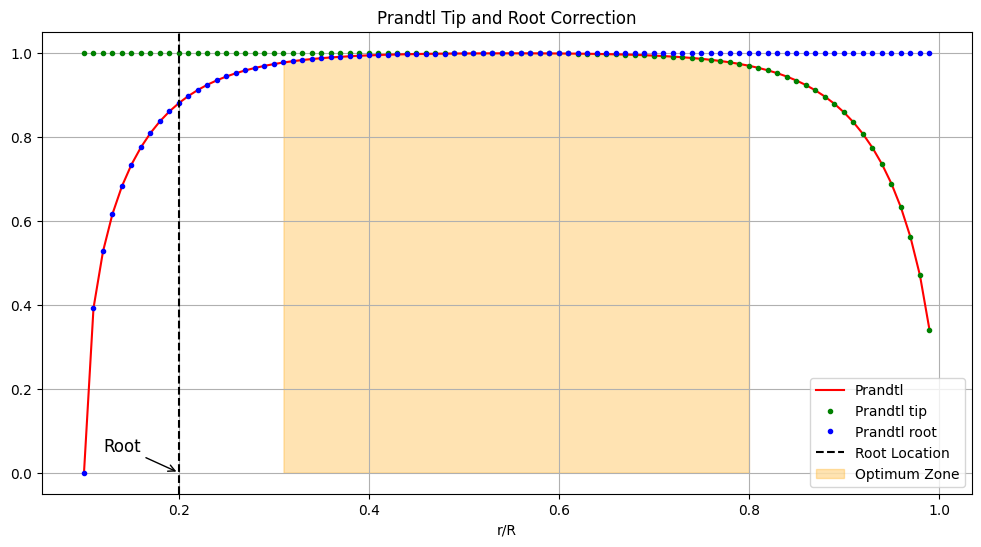

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, TSR, NBlades, axial_induction):
    """
    This function calculates the combined tip and root Prandtl correction at a given radial position 'r_R' (non-dimensionalized by rotor radius), 
    given a root and tip radius (also non-dimensionalized), a tip speed ratio TSR, the number of blades NBlades, and the axial induction factor.
      Args1:
      tipradius_R (float): Normalized tip position (ratio to rotor radius).
      rootradius_R (float): Root radius normalized by rotor radius (R).
      r_R (float): Normalized radial position along the blade (ratio to rotor radius).
      TSR (float): Tip speed ratio (ratio of blade tip speed to wind speed).
      NBlades (int): Number of blades.
      axial_induction (float): Axial induction factor (reduction in wind speed due to blade interaction).

  Returns:
   
          Ftotal (float): Combined tip and root correction factor(Froot*Ftip). 
          Ftip (float): Tip loss correction factor.
          Froot (float): Root loss correction factor.
  """

    temp1 = -NBlades/2*(tipradius_R-r_R)/r_R*np.sqrt(1+((TSR*r_R)**2)/((1-axial_induction)**2))
    Ftip = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Ftip[np.isnan(Ftip)] = 0
    temp1 = NBlades/2*(rootradius_R-r_R)/r_R*np.sqrt(1+((TSR*r_R)**2)/((1-axial_induction)**2))
    Froot = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Froot[np.isnan(Froot)] = 0
    return Froot*Ftip, Ftip, Froot

# Plot Prandtl tip, root, and combined correction for a number of blades and induction 'a', over the non-dimensional radius
r_R = np.arange(0.1, 1, .01)
a = np.zeros(np.shape(r_R)) + 0.3
Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, 0.1, 1, 7, 3, a)

fig1 = plt.figure(figsize=(12, 6))
plt.plot(r_R, Prandtl, 'r-', label='Prandtl')
plt.plot(r_R, Prandtltip, 'g.', label='Prandtl tip')
plt.plot(r_R, Prandtlroot, 'b.', label='Prandtl root')
plt.axvline(x=0.2, color='k', linestyle='--', label='Root Location')  # Adding the vertical dashed line at Root_Location (r/R = 0.2)

# Annotating the root location
#plt.text(0.19, 0.2, 'Root Location', fontsize=12, verticalalignment='top', horizontalalignment='right')
plt.annotate('Root', xy=(0.2, 0), xytext=(0.12, 0.05),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12)
plt.title('Prandtl Tip and Root Correction')
# Highlighting the optimum zone
plt.fill_between(r_R, Prandtl, where=(r_R >= 0.3) & (r_R <= 0.8), color='orange', alpha=0.3, label='Optimum Zone')
plt.grid(True)
plt.xlabel('r/R')
plt.legend()
plt.show()





By considering different parameters such as the number of blades and axial induction factors, the analysis provides objective insights into the aerodynamic characteristics of the rotor. These findings contribute to enhancing our understanding of wind turbine performance and support the optimization of wind energy systems.
The graph illustrates the Prandtl tip, root, and combined correction factors over the non-dimensional radius of the wind turbine blade. The highlighted orange zone represents the optimum zone, where the maximum energy extraction can be gained.

3# Define a function to determine load forces in the blade element
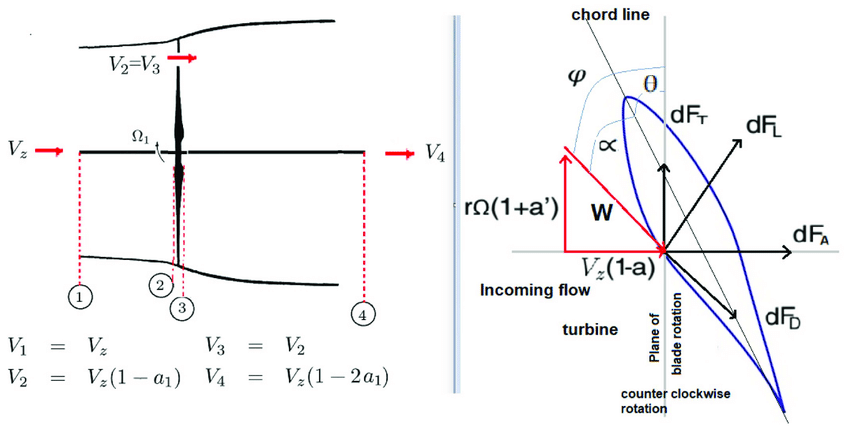

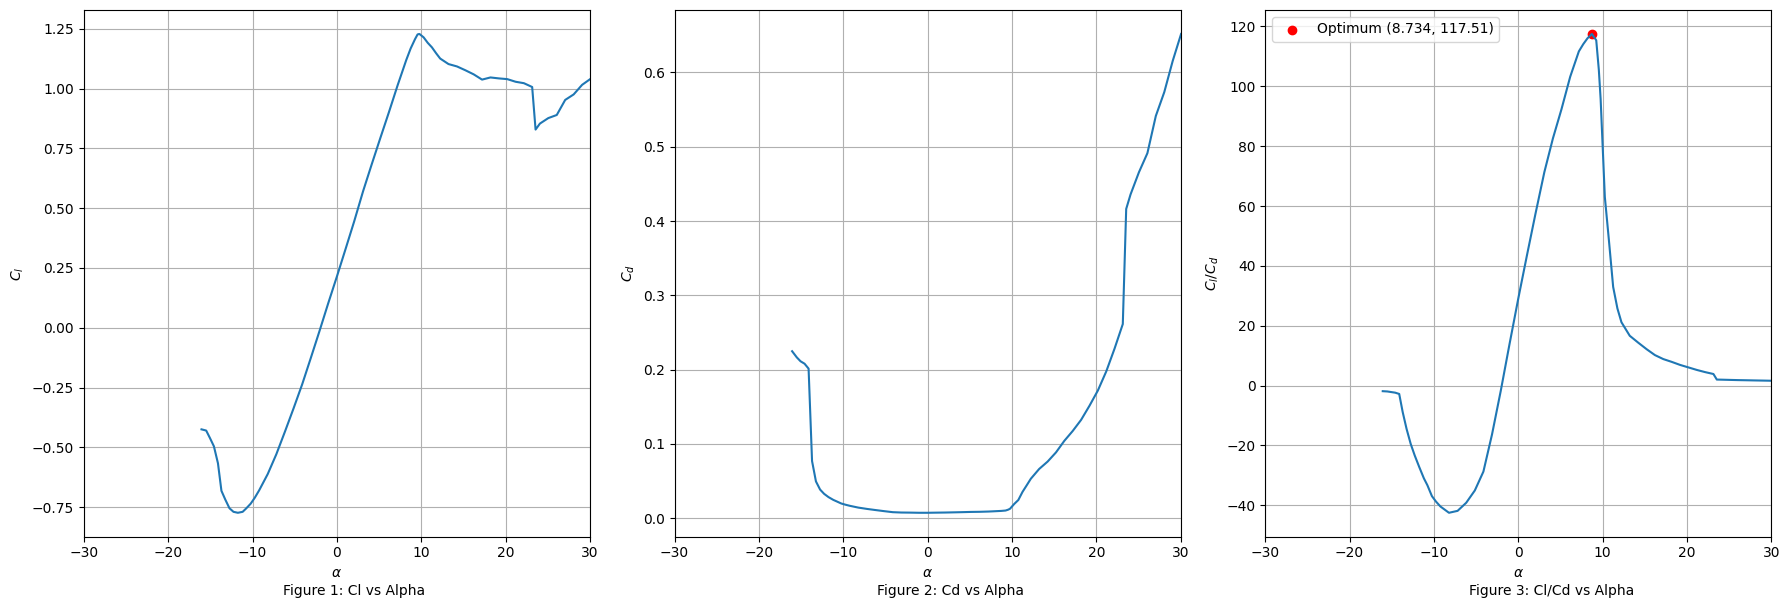

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
#airfoil = 'DU95W180.cvs'
#Import airfoil data
airfoil = 'polarDU95W180_.xlsx'
#airfoil = pd.read_excel(file_path)

data1=pd.read_excel(airfoil, header=0,names = ["alfa", "cl", "cd", "cm"])
polar_alpha = data1['alfa'][:]
polar_cl = data1['cl'][:]
polar_cd = data1['cd'][:]



import numpy as np
import matplotlib.pyplot as plt

# Assuming polar_alpha, polar_cl, and polar_cd are defined

# Calculate Cl/Cd
cl_cd_ratio = polar_cl / polar_cd

# Find the index of the maximum Cl/Cd ratio
optimum_index = np.argmax(cl_cd_ratio)
optimum_alpha = polar_alpha[optimum_index]
optimum_cl_cd = cl_cd_ratio[optimum_index]

# Create a new figure
plt.figure(figsize=(18, 6))

# Plot Cl vs Alpha
plt.subplot(131)
plt.plot(polar_alpha, polar_cl)
plt.xlim([-30, 30])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_l$')
plt.grid()
plt.figtext(0.16, 0.0, 'Figure 1: Cl vs Alpha', horizontalalignment='left', fontsize=10)

# Plot Cd vs Alpha
plt.subplot(132)
plt.plot(polar_alpha, polar_cd)
plt.xlim([-30, 30])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_d$')
plt.grid()
plt.figtext(0.49, 0, 'Figure 2: Cd vs Alpha', horizontalalignment='left', fontsize=10)

# Plot Cl/Cd vs Alpha
plt.subplot(133)
plt.plot(polar_alpha, cl_cd_ratio)
plt.xlim([-30, 30])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_l/C_d$')
plt.grid()
plt.figtext(0.819, 0.0, 'Figure 3: Cl/Cd vs Alpha', horizontalalignment='left', fontsize=10)

# Highlight optimum point
plt.scatter(optimum_alpha, optimum_cl_cd, color='red', label=f'Optimum ({optimum_alpha}, {optimum_cl_cd:.2f})')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()



In the above analysis, we explored the aerodynamic performance of an airfoil by examining the relationships between Angle of Attack (α)(AoA), lift coefficient (Cl), drag coefficient (Cd), and their ratio (Cl/Cd). By plotting these parameters against α, we gained insights into the airfoil's behavior across different operating conditions (AoA).

The most informative plot was the Cl/Cd vs α, as it depicted the airfoil's efficiency in terms of lift-to-drag ratio. This plot allowed us to identify the optimum operating point where the airfoil achieves the highest lift-to-drag ratio, indicating the most efficient configuration for a given angle of attack. Highlighting the optimum point emphasized the critical operating condition where the airfoil exhibits its best performance. 

4# Solve the balance of momentum between blade element and Aerodynamic load in the streamtube, Input variables:
(Uinf, r1_R, r2_R, rootradius_R, tipradius_R , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd ):
    Uinf: wind speed at infinity
    r1_R,r2_R: edges of blade element, in a fraction of rotor radius;
    rootradius_R, tipradius_R: location of blade root and tip, in a fraction of rotor radius;
    Radius: rotor radius
    Omega: rotational velocity
    NBlades: number of blades 
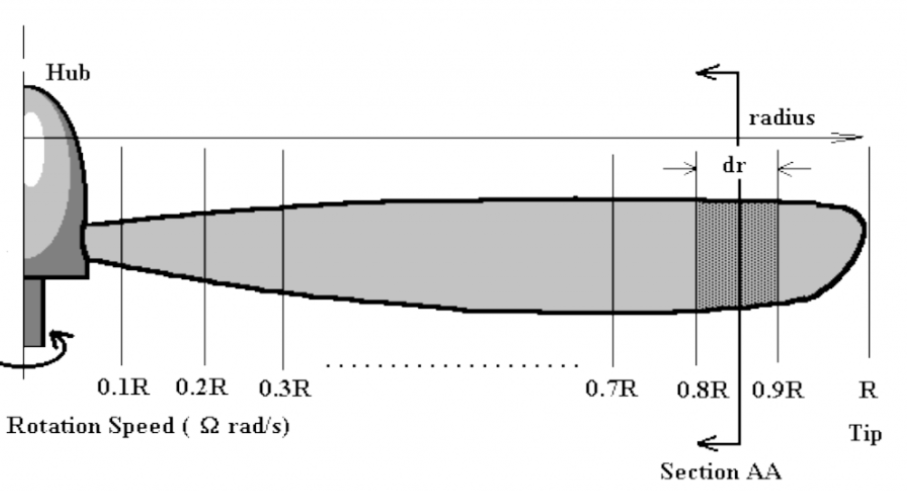
    
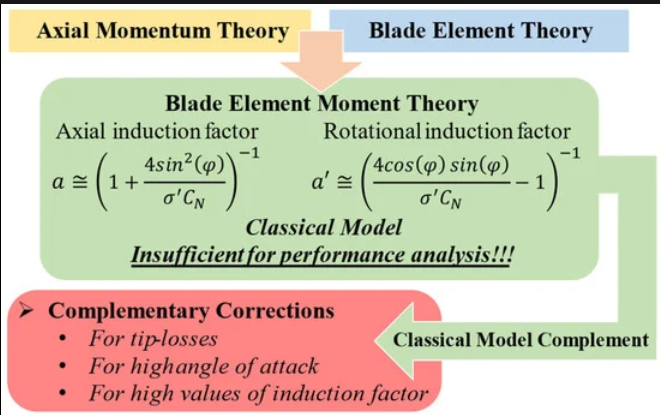 

Input variables: (Uinf, r1_R, r2_R, rootradius_R, tipradius_R, Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd ):
Uinf: wind speed at infinity.
r1_R,r2_R: edges of blade element, in a fraction of rotor radius.
rootradius_R, tipradius_R: location of blade root and tip, in a fraction of rotor radius.
Radius: rotor radius. 
Omega: rotational velocity NBlades: number of blades. 

           a     a_rot    r_R           Fn          Ft      gamma
0   0.431193  0.122209  0.205   406.758969  120.287789  22.017870
1   0.349428  0.089609  0.215   563.841427  189.621902  29.984548
2   0.308881  0.072223  0.225   644.905615  224.280846  33.305285
3   0.281887  0.060512  0.235   701.185602  245.437037  35.055131
4   0.261814  0.051867  0.245   744.999685  259.217181  36.019939
..       ...       ...    ...          ...         ...        ...
75  0.182208  0.002408  0.955  2050.204229  191.491605  26.732840
76  0.197048  0.002546  0.965  2026.084368  182.968631  26.141848
77  0.219844  0.002773  0.975  1980.521042  170.598138  25.287045
78  0.260713  0.003194  0.985  1888.280974  150.062708  23.855545
79  0.368350  0.004228  0.995  1607.502026  101.307801  20.084457

[80 rows x 6 columns]
CT is  0.4284491035135839
CP is  0.3264397910482987


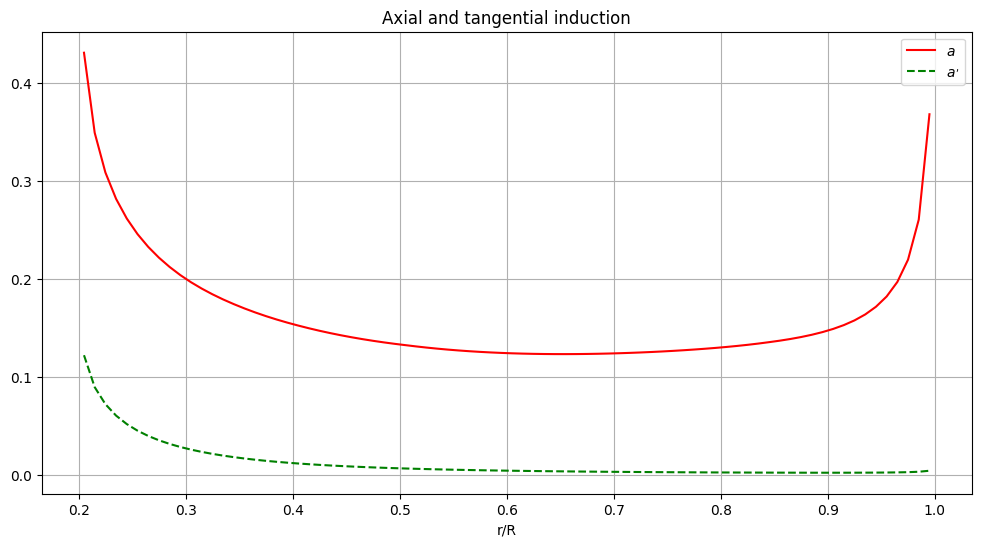

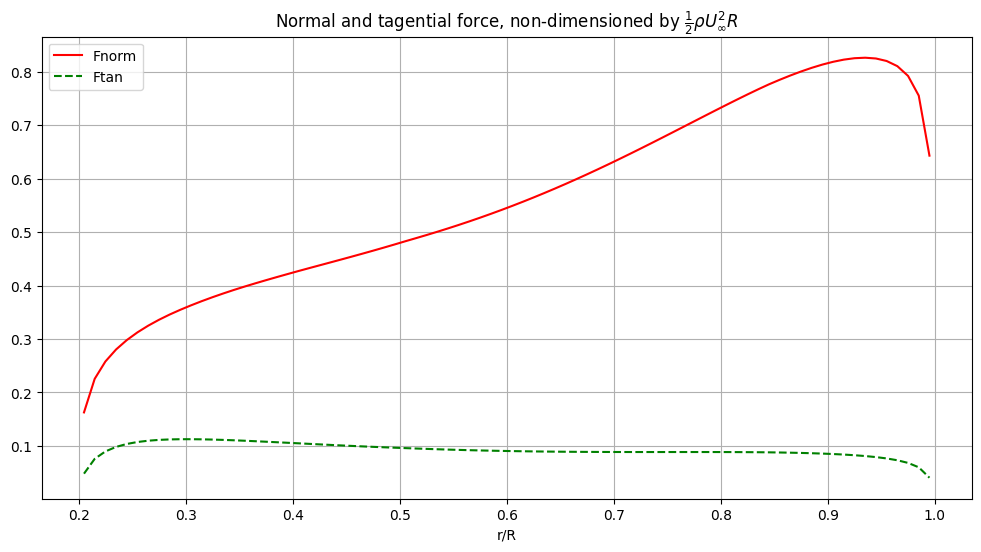

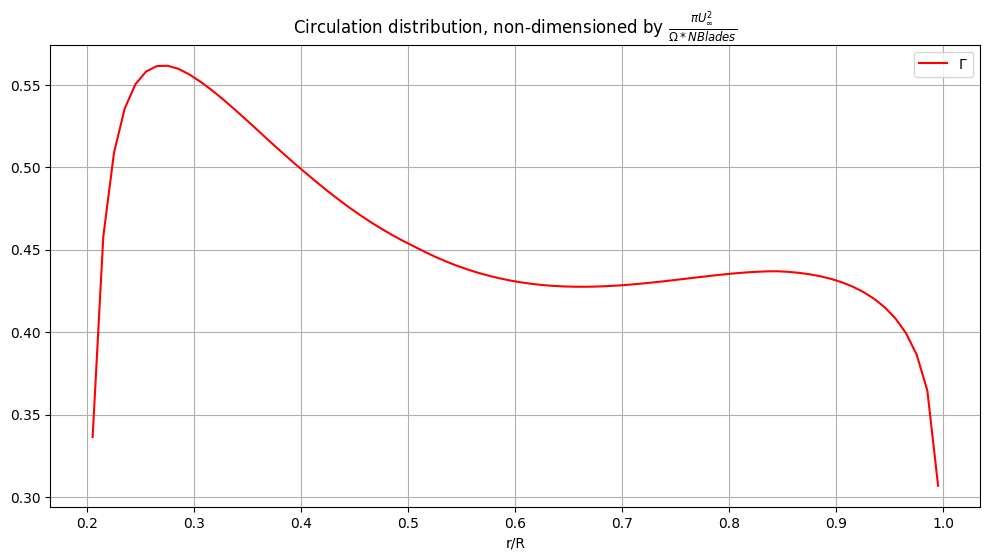

In [4]:
import numpy as np

# define function to determine load in the blade element
def loadBladeElement(vnorm, vtan, r_R, chord, twist, polar_alpha, polar_cl, polar_cd):
    """
    calculates the load in the blade element
    """
    vmag2 = vnorm**2 + vtan**2
    inflowangle = np.arctan2(vnorm, vtan)
    #alpha = inflowangle*180/np.pi - twist
    #alpha = inflowangle - twist
    alpha = twist + inflowangle*180/np.pi
    cl = np.interp(alpha, polar_alpha, polar_cl)
    cd = np.interp(alpha, polar_alpha, polar_cd)
    lift = 0.5 * vmag2 * cl * chord
    drag = 0.5 * vmag2 * cd * chord
    fnorm = lift * np.cos(inflowangle) + drag * np.sin(inflowangle)
    ftan = lift * np.sin(inflowangle) - drag * np.cos(inflowangle)
    gamma = 0.5 * np.sqrt(vmag2) * cl * chord
    return fnorm, ftan, gamma
def solveStreamtube(Uinf, r1_R, r2_R, rootradius_R, tipradius_R , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd):
    Area = np.pi * ((r2_R * Radius)**2 - (r1_R * Radius)**2)
    r_R = (r1_R + r2_R) / 2
    a = 0.0
    a_rot = 0.0
    N_iterations = 100
    Erroriterations = 0.00001
    for i in range(N_iterations):
       #################################################################################
        ### The following snippet calculates velocities and loads at the blade element ##
        #################################################################################
        Urotor = Uinf * (1 - a)  # Calculate axial velocity at rotor
        Utan = (1 + a_rot) * Omega * r_R * Radius # Calculate tangential velocity at rotor
        
               # Calculate loads in blade segment in 2D (N/m)
        fnorm , ftan, gamma = loadBladeElement(Urotor, Utan, r_R, chord, twist, polar_alpha, polar_cl, polar_cd)
        # the total axial force exerted by the blade element, taking into account its distribution along the radial and spanwise directions, 
        # as well as the number of blades in the rotor.
        load3Daxial = fnorm * Radius * (r2_R - r1_R) * NBlades #(N)
        ##################################################################################
        ###### The following snippet the new  axial and azimuthal inductions #############
        ##################################################################################
        CT = load3Daxial / (0.5 * Area * Uinf ** 2) # Calculate the thrust coefficient at the streamtube.
        anew = ainduction(CT) # Calculate new axial induction
        # Recalculate the new axial induction considering Prandtl's correction
        Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, Omega*Radius/Uinf, NBlades, anew);
        if (Prandtl < 0.0001): 
            Prandtl = 0.0001 # avoid divide by zero
        anew = anew/Prandtl # correct estimate of axial induction
        a = 0.75*a+0.25*anew # for improving convergence, weighing current and previous iterations of axial induction
 # calculate azimuthal induction
        a_rot = ftan*NBlades/(2*np.pi*Uinf*(1-a)*Omega*2*(r_R*Radius)**2)
        a_rot =a_rot/Prandtl # correct estimate of azimuthal induction with Prandtl's correction
       ##################################################################################
       #### Setting convergence criteria of axial induction #############################
       ################################################################################## 
        if (np.abs(a-anew) < Erroriterations): 
            # print("iterations")
            # print(i)
            break

    return [a , a_rot, r_R, fnorm , ftan, gamma] 



#################################################################

# define the blade geometry
delta_r_R = .01
r_R = np.arange(0.2, 1+delta_r_R/2, delta_r_R) #generates an array r_R, starting from root location


# blade shape
pitch = -2 # degrees
chord_distribution = 3*(1-r_R)+1 # meters
twist_distribution = -14*(1-r_R)+pitch # degrees



# define flow  conditions and blade parameters
Uinf = 10 # unperturbed wind speed in m/s
rho = 1.25 #air density kg/m3

TSR =  8 #6 #8 # 10 # tip speed ratios
TSR_values = np.linspace(6, 10, 2)  # TSR from 6 to 10 with 2 points

Radius = 50
Omega = Uinf*TSR/Radius
NBlades = 3

TipLocation_R =  1 # location of blade tip (fraction of Radius)
RootLocation_R =  0.2  # location of blade root (fraction of Radius)


# solve BEM model
results =np.zeros([len(r_R)-1,6]) 

for i in range(len(r_R)-1):
    chord = np.interp((r_R[i]+r_R[i+1])/2, r_R, chord_distribution)
    twist = np.interp((r_R[i]+r_R[i+1])/2, r_R, twist_distribution)

    # Returns : [a , a_rot, r_R, fnorm , ftan, gamma]
    results[i,:] = solveStreamtube(Uinf, r_R[i], r_R[i+1], RootLocation_R, TipLocation_R , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd )
    # Convert the data to a DataFrame (table)

df = pd.DataFrame(results, columns=['a', 'a_rot', 'r_R', 'Fn', 'Ft', 'gamma'])



############################################################################

areas = (r_R[1:]**2-r_R[:-1]**2)*np.pi*Radius**2 #calculate the area of each annular ring section along the radial direction
#Incremental radial spacing between adjacent elements:
dr = (r_R[1:]-r_R[:-1])*Radius #Multiplying by Radius to convert the non-dimensional radial coordinates (r_R) to actual physical distances in meters
CT = np.sum(dr*results[:,3]*NBlades/(0.5*Uinf**2*np.pi*Radius**2)) # results[:,3]= fnorm
CP = np.sum(dr*results[:,4]*results[:,2]*NBlades*Radius*Omega/(0.5*Uinf**3*np.pi*Radius**2))# results[:,4]= ftan
# Display the DataFrame
print(df)
print("CT is ", CT)
print("CP is ", CP)
################################################################################


fig1 = plt.figure(figsize=(12, 6))
plt.title('Axial and tangential induction')
plt.plot(results[:,2], results[:,0], 'r-', label=r'$a$')
plt.plot(results[:,2], results[:,1], 'g--', label=r'$a^,$')
plt.grid()
plt.xlabel('r/R')
plt.legend()
plt.show()

###################################################


fig1 = plt.figure(figsize=(12, 6))
plt.title(r'Normal and tagential force, non-dimensioned by $\frac{1}{2} \rho U_\infty^2 R$')
plt.plot(results[:,2], results[:,3]/(0.5*Uinf**2*Radius), 'r-', label=r'Fnorm')
plt.plot(results[:,2], results[:,4]/(0.5*Uinf**2*Radius), 'g--', label=r'Ftan')
plt.grid()
plt.xlabel('r/R')
plt.legend()
plt.show()
######################################

fig1 = plt.figure(figsize=(12, 6))
plt.title(r'Circulation distribution, non-dimensioned by $\frac{\pi U_\infty^2}{\Omega * NBlades } $')
plt.plot(results[:,2], results[:,5]/(np.pi*Uinf**2/(NBlades*Omega)), 'r-', label=r'$\Gamma$')
plt.grid()
plt.xlabel('r/R')
plt.legend()
plt.show()

## The collective Cell

1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000004
1.5000000000000004
1.6000000000000005
1.7000000000000006
1.8000000000000007
1.9000000000000008
2.000000000000001
2.100000000000001
2.200000000000001
2.300000000000001
2.4000000000000012
2.5000000000000013
2.6000000000000014
2.7000000000000015
2.8000000000000016
2.9000000000000017
3.0000000000000018
3.100000000000002
3.200000000000002
3.300000000000002
3.400000000000002
3.500000000000002
3.6000000000000023
3.7000000000000024
3.8000000000000025
3.9000000000000026
4.000000000000003
4.100000000000003
4.200000000000003
4.3000000000000025
4.400000000000003
4.5000000000000036
4.600000000000003
4.700000000000003
4.800000000000003
4.900000000000004
5.0000000000000036
5.100000000000003
5.200000000000004
5.300000000000004
5.400000000000004
5.5000000000000036
5.600000000000004
5.700000000000005
5.800000000000004
5.900000000000004
6.000000000000004
6.100000000000005
6.200000000000005
6.300000000000004
6.400000000000005
6.5000000000000

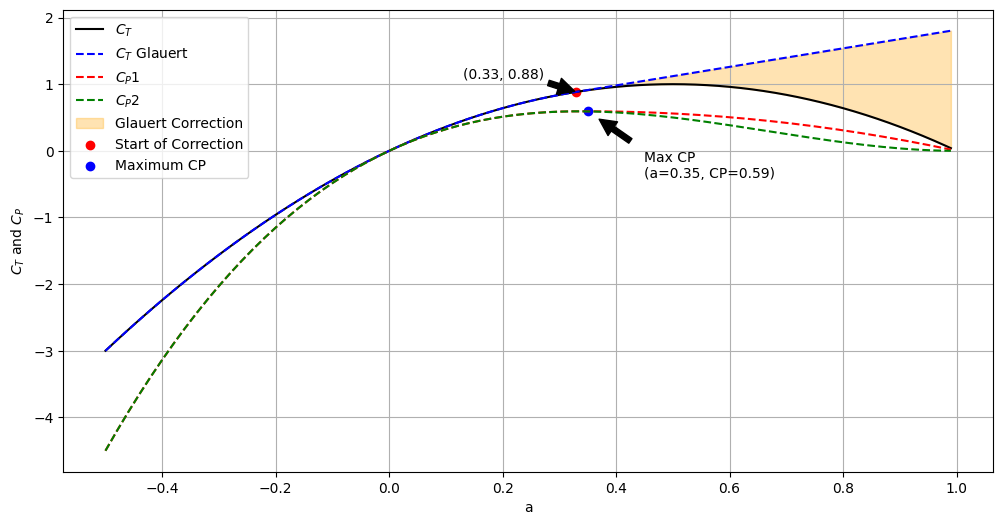

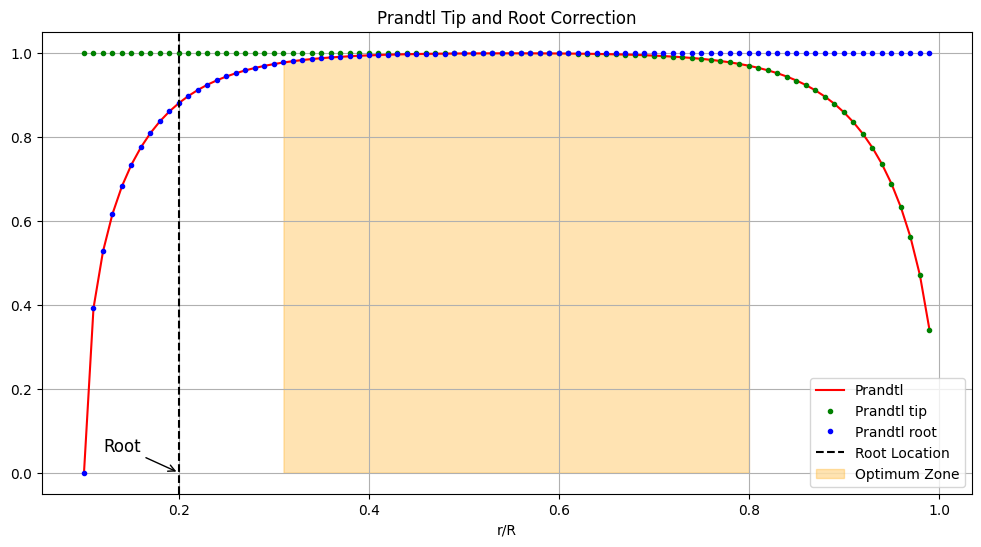

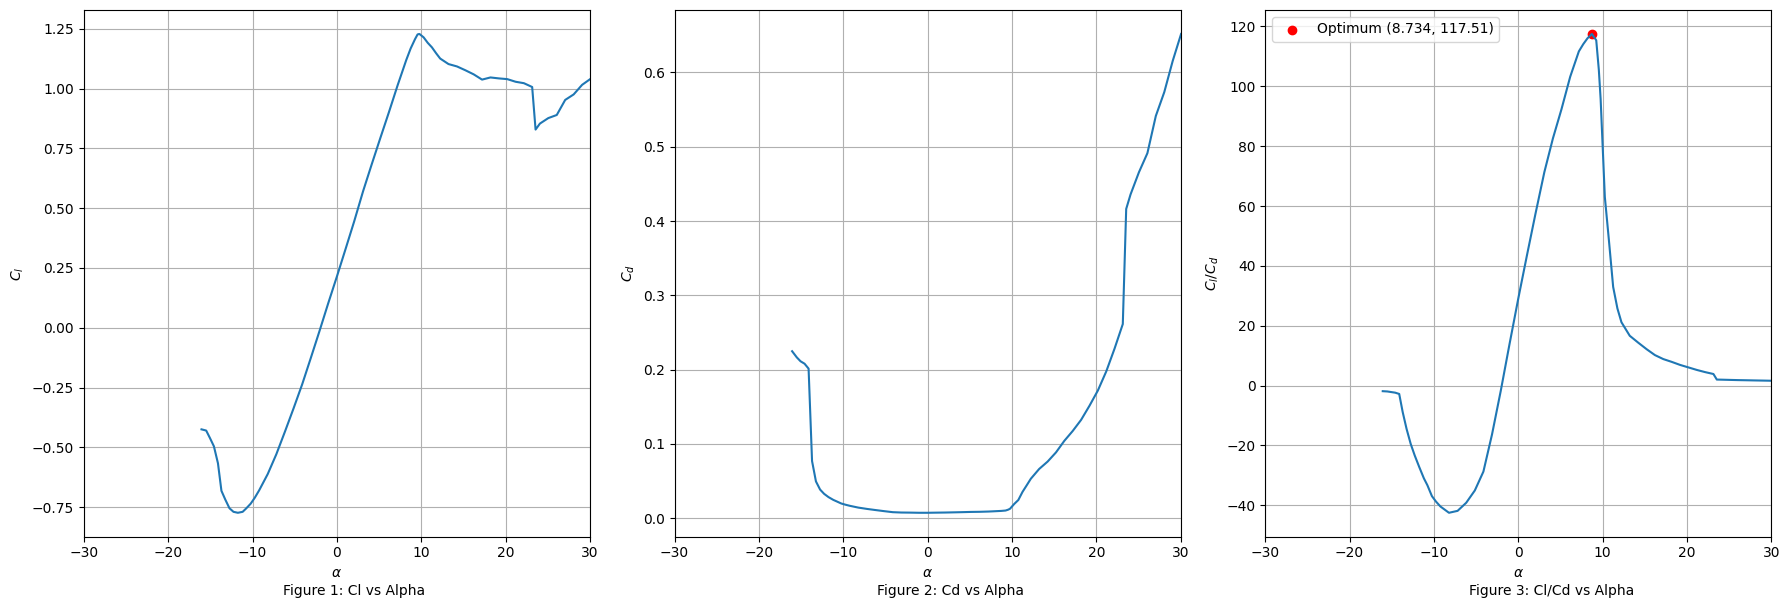

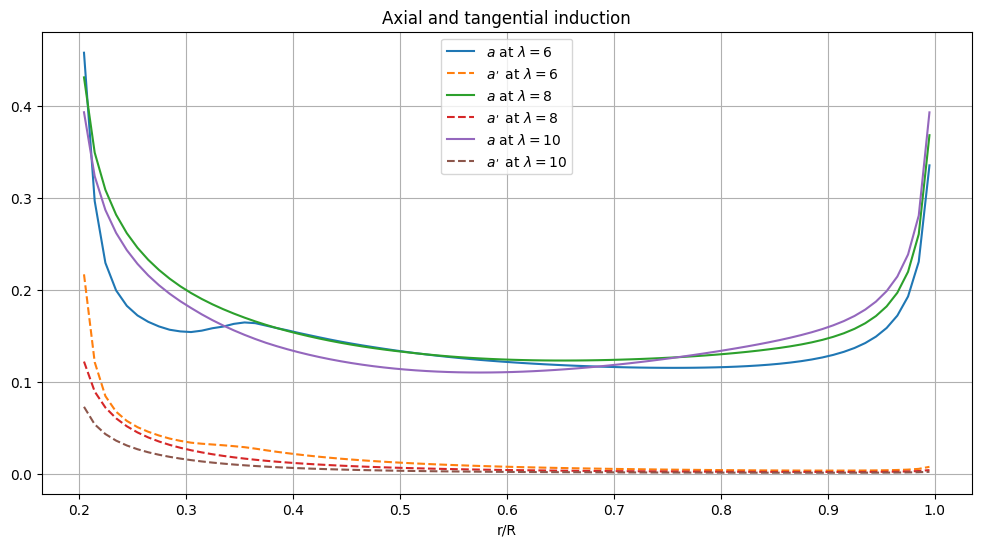

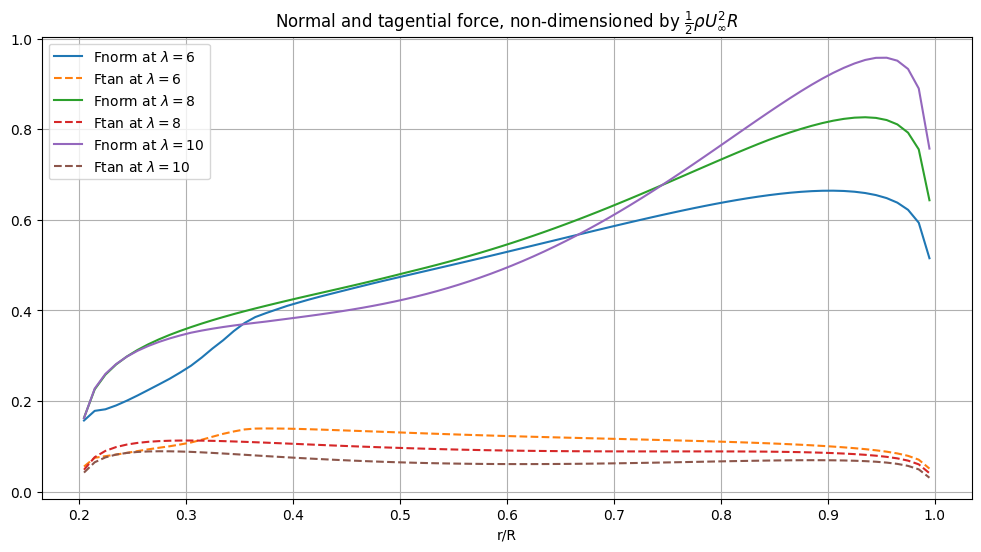

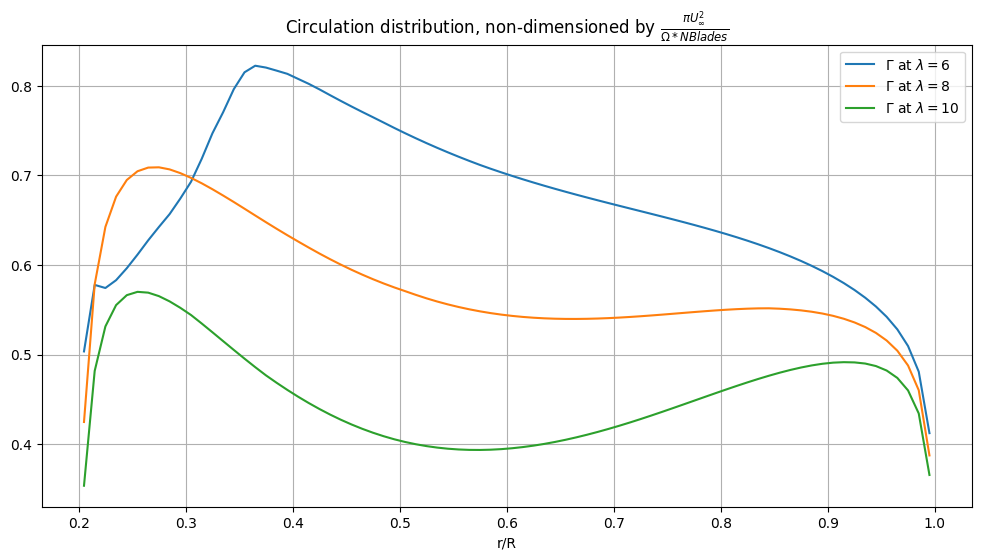

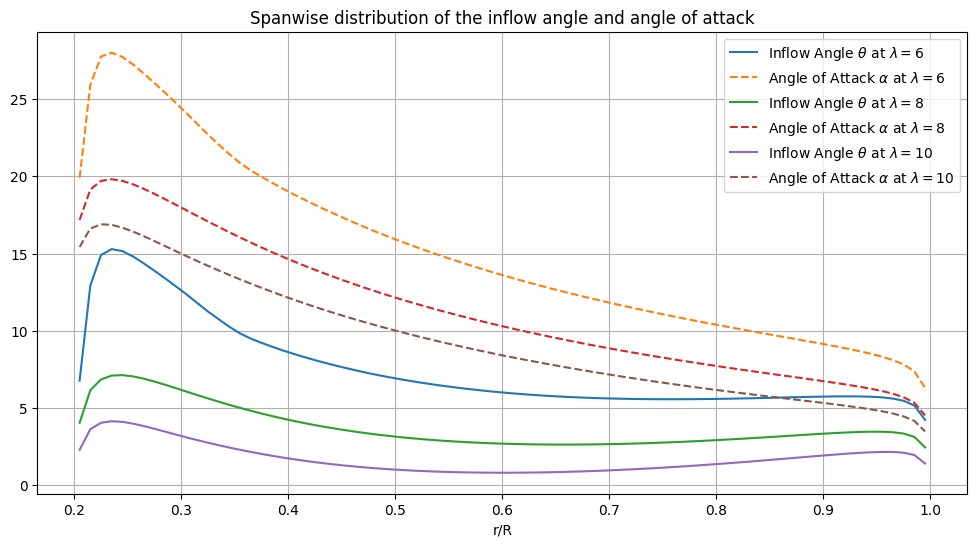

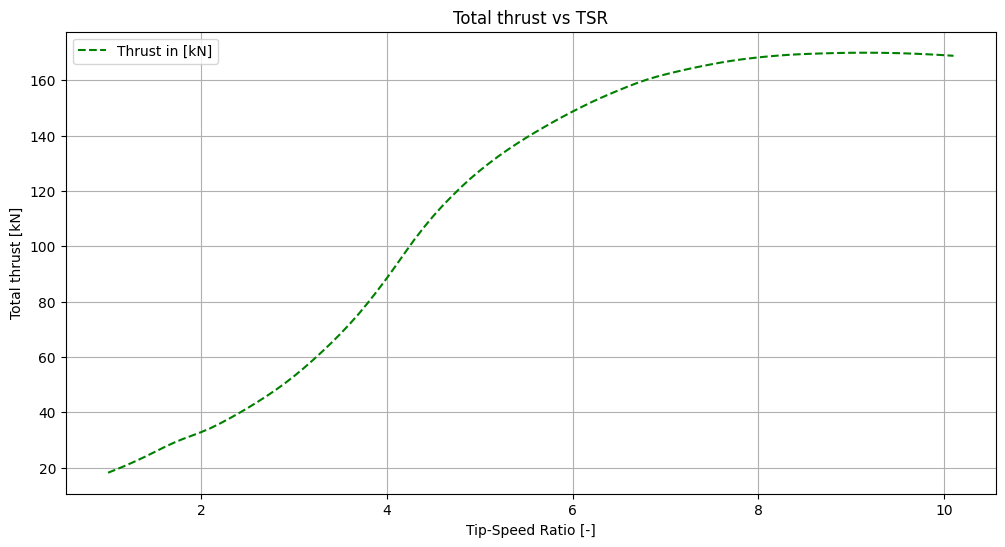

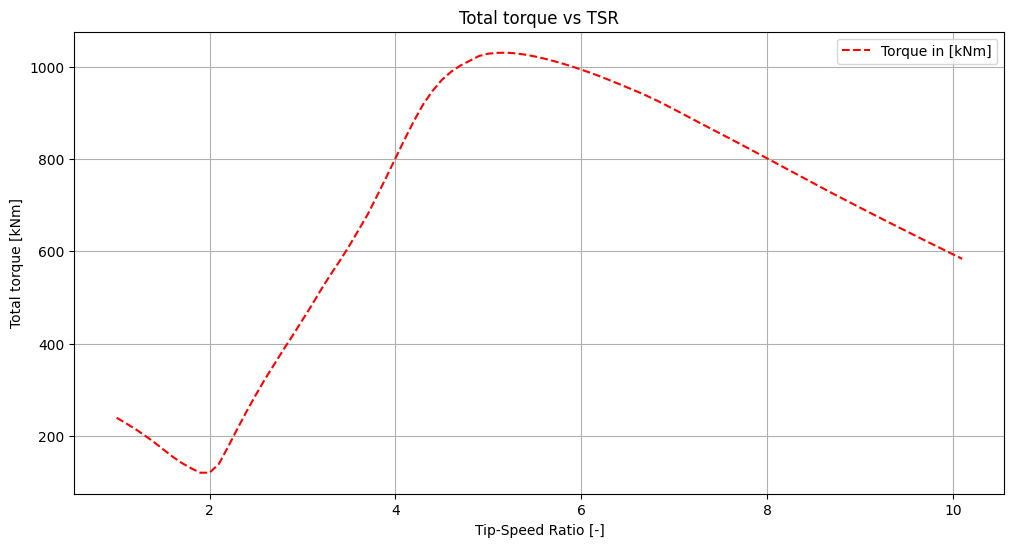

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def CTfunction(a, glauert=False):
    """
    Calculate the thrust coefficient as a function of induction factor 'a'.
    """
    CT = np.zeros_like(a)  # Initialize array for thrust coefficient

    # Calculate the thrust coefficient using the original formula with no corrections yet.
    CT = 4 * a * (1 - a)  # Valide for Light loaded rotor, where a < (1-(√(CT1)/2)); where CT1=1.816

    # Apply Glauert's correction if specified
    if glauert:
        CT1 = 1.816
        a1 = 1 - np.sqrt(CT1) / 2  # threshold criterion
        CT[a > a1] = CT1 - 4 * (np.sqrt(CT1) - 1) * (
                    1 - a[a > a1])  # Applying Glauert's correction for the zone of a > a1; where a1 = (1-(√(CT1)/2))

    return CT


def ainduction(CT):
    """
    Calculate the induction factor 'a' as a function of thrust coefficient 'CT' including Glauert's correction.
    """
    a = np.zeros_like(CT)  # Initialize array for induction factor

    # Define Glauert's constants and thresholds
    CT1 = 1.816
    CT2 = 2 * np.sqrt(CT1) - CT1  # threshold criterion CT2 = 2x√(CT1)-CT1

    # Calculate the induction factor with Glauert's correction
    a[CT < CT2] = 0.5 - 0.5 * np.sqrt(1 - CT[CT < CT2])  # For the zone of CT < CT2; where CT2 = 2x√(CT1)-CT1
    a[CT >= CT2] = 1 + (CT[CT >= CT2] - CT1) / (
                4 * (np.sqrt(CT1) - 1))  # Glauert's correction. Applicable where CT >= CT2

    return a


# Plot CT as a function of induction "a", with and without Glauert correction
# Define a as a range
a = np.arange(-.5, 1, .01)
CTmom = CTfunction(a)  # CT without correction
CTglauert = CTfunction(a, True)  # CT with Glauert's correction
a2 = ainduction(CTglauert)

# Diffrent Cp formulas
CP1 = CTglauert * (1 - a)  # 1st Cp formula
CP2 = 4 * a * (1 - a) ** 2  # 2nd Cp formulas

# Find the index where Glauert's correction starts
highlight_indices = a > (1 - np.sqrt(1.816) / 2)  # Highlight Zone Where Glauert's Correction is Applied
start_index = np.argmax(highlight_indices)

max_cp_value = np.max(CTglauert * (1 - a))
max_cp_index = np.argmax(CTglauert * (1 - a))
optimum_a = a[max_cp_index]

fig1 = plt.figure(figsize=(12, 6))
plt.plot(a, CTmom, 'k-', label='$C_T$')
plt.plot(a, CTglauert, 'b--', label='$C_T$ Glauert')
plt.plot(a, CP1, 'r--', label='$C_P1$ ')
plt.plot(a, CP2, 'g--', label='$C_P2$ ')
plt.fill_between(a, CTmom, CTglauert, where=highlight_indices, color='orange', alpha=0.3, label="Glauert Correction")
plt.scatter(a[start_index], CTglauert[start_index], color='red', label='Start of Correction')
plt.annotate(f"({a[start_index]:.2f}, {CTglauert[start_index]:.2f})", xy=(a[start_index], CTglauert[start_index]),
             xytext=(a[start_index] - 0.2, CTglauert[start_index] + 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05))
# plt.axvline(x=a[optimum_cp_index], color='green', linestyle='--', label='Optimum CP')
plt.scatter(optimum_a, max_cp_value, color='blue', label='Maximum CP')
plt.annotate(f"Max CP\n(a={optimum_a:.2f}, CP={max_cp_value:.2f})", xy=(optimum_a, max_cp_value),
             xytext=(optimum_a + 0.1, max_cp_value - 1), arrowprops=dict(facecolor='black', shrink=0.2))
plt.xlabel('a')
plt.ylabel(r'$C_T$ and $C_P$')
plt.grid()
plt.legend()
#plt.savefig("Glauertplot.jpg")
#plt.show()

#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


import numpy as np
import matplotlib.pyplot as plt


def PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, TSR, NBlades, axial_induction):
    """
    This function calculates the combined tip and root Prandtl correction at a given radial position 'r_R' (non-dimensionalized by rotor radius),
    given a root and tip radius (also non-dimensionalized), a tip speed ratio TSR, the number of blades NBlades, and the axial induction factor.
      Args1:
      tipradius_R (float): Normalized tip position (ratio to rotor radius).
      rootradius_R (float): Root radius normalized by rotor radius (R).
      r_R (float): Normalized radial position along the blade (ratio to rotor radius).
      TSR (float): Tip speed ratio (ratio of blade tip speed to wind speed).
      NBlades (int): Number of blades.
      axial_induction (float): Axial induction factor (reduction in wind speed due to blade interaction).

  Returns:

          Ftotal (float): Combined tip and root correction factor(Froot*Ftip).
          Ftip (float): Tip loss correction factor.
          Froot (float): Root loss correction factor.
  """

    temp1 = -NBlades / 2 * (tipradius_R - r_R) / r_R * np.sqrt(1 + ((TSR * r_R) ** 2) / ((1 - axial_induction) ** 2))
    Ftip = np.array(2 / np.pi * np.arccos(np.exp(temp1)))
    Ftip[np.isnan(Ftip)] = 0
    temp1 = NBlades / 2 * (rootradius_R - r_R) / r_R * np.sqrt(1 + ((TSR * r_R) ** 2) / ((1 - axial_induction) ** 2))
    Froot = np.array(2 / np.pi * np.arccos(np.exp(temp1)))
    Froot[np.isnan(Froot)] = 0
    return Froot * Ftip, Ftip, Froot


# Plot Prandtl tip, root, and combined correction for a number of blades and induction 'a', over the non-dimensional radius
r_R = np.arange(0.1, 1, .01)
a = np.zeros(np.shape(r_R)) + 0.3
Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, 0.1, 1, 7, 3, a)

fig1 = plt.figure(figsize=(12, 6))
plt.plot(r_R, Prandtl, 'r-', label='Prandtl')
plt.plot(r_R, Prandtltip, 'g.', label='Prandtl tip')
plt.plot(r_R, Prandtlroot, 'b.', label='Prandtl root')
plt.axvline(x=0.2, color='k', linestyle='--',
            label='Root Location')  # Adding the vertical dashed line at Root_Location (r/R = 0.2)

# Annotating the root location
# plt.text(0.19, 0.2, 'Root Location', fontsize=12, verticalalignment='top', horizontalalignment='right')
plt.annotate('Root', xy=(0.2, 0), xytext=(0.12, 0.05),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12)
plt.title('Prandtl Tip and Root Correction')
# Highlighting the optimum zone
plt.fill_between(r_R, Prandtl, where=(r_R >= 0.3) & (r_R <= 0.8), color='orange', alpha=0.3, label='Optimum Zone')
plt.grid(True)
plt.xlabel('r/R')
plt.legend()
#plt.savefig("Prandtlplot.jpg")
#plt.show()


#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx



import pandas as pd
import matplotlib.pyplot as plt
#airfoil = 'DU95W180.cvs'
#Import airfoil data
airfoil = 'polarDU95W180_.xlsx'
#airfoil = pd.read_excel(file_path)

data1=pd.read_excel(airfoil, header=0,names = ["alfa", "cl", "cd", "cm"])
polar_alpha = data1['alfa'][:]
polar_cl = data1['cl'][:]
polar_cd = data1['cd'][:]



import numpy as np
import matplotlib.pyplot as plt

# Assuming polar_alpha, polar_cl, and polar_cd are defined

# Calculate Cl/Cd
cl_cd_ratio = polar_cl / polar_cd

# Find the index of the maximum Cl/Cd ratio
optimum_index = np.argmax(cl_cd_ratio)
optimum_alpha = polar_alpha[optimum_index]
optimum_cl_cd = cl_cd_ratio[optimum_index]

# Create a new figure
plt.figure(figsize=(18, 6))

# Plot Cl vs Alpha
plt.subplot(131)
plt.plot(polar_alpha, polar_cl)
plt.xlim([-30, 30])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_l$')
plt.grid()
plt.figtext(0.16, 0.0, 'Figure 1: Cl vs Alpha', horizontalalignment='left', fontsize=10)

# Plot Cd vs Alpha
plt.subplot(132)
plt.plot(polar_alpha, polar_cd)
plt.xlim([-30, 30])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_d$')
plt.grid()
plt.figtext(0.49, 0, 'Figure 2: Cd vs Alpha', horizontalalignment='left', fontsize=10)

# Plot Cl/Cd vs Alpha
plt.subplot(133)
plt.plot(polar_alpha, cl_cd_ratio)
plt.xlim([-30, 30])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_l/C_d$')
plt.grid()
plt.figtext(0.819, 0.0, 'Figure 3: Cl/Cd vs Alpha', horizontalalignment='left', fontsize=10)

# Highlight optimum point
plt.scatter(optimum_alpha, optimum_cl_cd, color='red', label=f'Optimum ({optimum_alpha}, {optimum_cl_cd:.2f})')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
#plt.savefig("Polarsplot.jpg")
#plt.show()


#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx



import numpy as np


# define function to determine load in the blade element
def loadBladeElement(vnorm, vtan, r_R, chord, twist, polar_alpha, polar_cl, polar_cd):
    """
    calculates the load in the blade element
    """
    vmag2 = vnorm ** 2 + vtan ** 2
    inflowangle = np.arctan2(vnorm, vtan)
    # alpha = inflowangle*180/np.pi - twist
    # alpha = inflowangle - twist
    alpha = twist + inflowangle * 180 / np.pi
    cl = np.interp(alpha, polar_alpha, polar_cl)
    cd = np.interp(alpha, polar_alpha, polar_cd)
    lift = 0.5 * vmag2 * cl * chord
    drag = 0.5 * vmag2 * cd * chord
    fnorm = lift * np.cos(inflowangle) + drag * np.sin(inflowangle)
    ftan = lift * np.sin(inflowangle) - drag * np.cos(inflowangle)
    gamma = 0.5 * np.sqrt(vmag2) * cl * chord
    return fnorm, ftan, gamma, alpha, inflowangle*180/np.pi


def solveStreamtube(Uinf, r1_R, r2_R, rootradius_R, tipradius_R, Omega, Radius, NBlades, chord, twist, polar_alpha,
                    polar_cl, polar_cd):
    Area = np.pi * ((r2_R * Radius) ** 2 - (r1_R * Radius) ** 2)
    r_R = (r1_R + r2_R) / 2
    a = 0.0
    a_rot = 0.0
    N_iterations = 100
    Erroriterations = 0.00001
    for i in range(N_iterations):
        #################################################################################
        ### The following snippet calculates velocities and loads at the blade element ##
        #################################################################################
        Urotor = Uinf * (1 - a)  # Calculate axial velocity at rotor
        Utan = (1 + a_rot) * Omega * r_R * Radius  # Calculate tangential velocity at rotor

        # Calculate loads in blade segment in 2D (N/m)
        fnorm, ftan, gamma, alpha, inflowangle = loadBladeElement(Urotor, Utan, r_R, chord, twist, polar_alpha, polar_cl, polar_cd)
        # the total axial force exerted by the blade element, taking into account its distribution along the radial and spanwise directions,
        # as well as the number of blades in the rotor.
        load3Daxial = fnorm * Radius * (r2_R - r1_R) * NBlades  # (N)
        ##################################################################################
        ###### The following snippet the new  axial and azimuthal inductions #############
        ##################################################################################
        CT = load3Daxial / (0.5 * Area * Uinf ** 2)  # Calculate the thrust coefficient at the streamtube.
        anew = ainduction(CT)  # Calculate new axial induction
        # Recalculate the new axial induction considering Prandtl's correction
        Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R,
                                                                    Omega * Radius / Uinf, NBlades, anew);
        if (Prandtl < 0.0001):
            Prandtl = 0.0001  # avoid divide by zero
        anew = anew / Prandtl  # correct estimate of axial induction
        a = 0.75 * a + 0.25 * anew  # for improving convergence, weighing current and previous iterations of axial induction
        # calculate azimuthal induction
        a_rot = ftan * NBlades / (2 * np.pi * Uinf * (1 - a) * Omega * 2 * (r_R * Radius) ** 2)
        a_rot = a_rot / Prandtl  # correct estimate of azimuthal induction with Prandtl's correction
        ##################################################################################
        #### Setting convergence criteria of axial induction #############################
        ##################################################################################
        if (np.abs(a - anew) < Erroriterations):
            # print("iterations")
            # print(i)
            break

    return [a, a_rot, r_R, fnorm, ftan, gamma, alpha, inflowangle]


#################################################################

# define the blade geometry
delta_r_R = .01
r_R = np.arange(0.2, 1 + delta_r_R / 2, delta_r_R)  # generates an array r_R, starting from root location

# blade shape
pitch = -2  # degrees
chord_distribution = 3 * (1 - r_R) + 1  # meters
twist_distribution = -14 * (1 - r_R) + pitch  # degrees

# define flow  conditions and blade parameters
Uinf = 10  # unperturbed wind speed in m/s
rho = 1.25  # air density kg/m3


dictionary = {}
Radius = 50
NBlades = 3

TipLocation_R = 1  # location of blade tip (fraction of Radius)
RootLocation_R = 0.2  # location of blade root (fraction of Radius)


#TSR = 8  # 6 #8 # 10 # tip speed ratios
TSR_values = np.arange(1, 10.2, 0.1)  # TSR from 6 to 10 with 2 points
for TSR in TSR_values:
    print(TSR)
    Omega = Uinf * TSR / Radius

    # solve BEM model
    results = np.zeros([len(r_R) - 1, 8])

    for i in range(len(r_R) - 1):
        chord = np.interp((r_R[i] + r_R[i + 1]) / 2, r_R, chord_distribution)
        twist = np.interp((r_R[i] + r_R[i + 1]) / 2, r_R, twist_distribution)

        # Returns : [a , a_rot, r_R, fnorm , ftan, gamma]
        results[i, :] = solveStreamtube(Uinf, r_R[i], r_R[i + 1], RootLocation_R, TipLocation_R, Omega, Radius, NBlades,
                                        chord, twist, polar_alpha, polar_cl, polar_cd)
        # Convert the data to a DataFrame (table)
        dictionary[TSR] = results

#df = pd.DataFrame(dictionary[8], columns=['a', 'a_rot', 'r_R', 'Fn', 'Ft', 'gamma', "alpha", "inflowangle"])

thrustlist = []
powerlist = []

############################################################################
plotlist = []
for TSR in TSR_values:
    if np.round(TSR, 4) == 6 or np.round(TSR, 4) == 8 or np.round(TSR, 4) == 10:
        plotlist.append(TSR)
print(plotlist)

fig1 = plt.figure(figsize=(12, 6))
plt.title('Axial and tangential induction')
for TSR in plotlist:
    plt.plot(dictionary[TSR][:, 2], dictionary[TSR][:, 0], '-', label=r'$a$ at $\lambda=$'+str(round(TSR)))
    plt.plot(dictionary[TSR][:, 2], dictionary[TSR][:, 1], '--', label=r'$a^,$ at $\lambda=$'+str(round(TSR)))
plt.grid()
plt.xlabel('r/R')
plt.legend()
#plt.savefig("inductionplot.jpg")
plt.show()

###################################################

fig1 = plt.figure(figsize=(12, 6))
plt.title(r'Normal and tagential force, non-dimensioned by $\frac{1}{2} \rho U_\infty^2 R$')
for TSR in plotlist:
    plt.plot(dictionary[TSR][:, 2], dictionary[TSR][:, 3] / (0.5 * Uinf ** 2 * Radius), '-', label=r'Fnorm at $\lambda=$'+str(round(TSR)))
    plt.plot(dictionary[TSR][:, 2], dictionary[TSR][:, 4] / (0.5 * Uinf ** 2 * Radius), '--', label=r'Ftan at $\lambda=$'+str(round(TSR)))
plt.grid()
plt.xlabel('r/R')
plt.legend()
#plt.savefig("Forcesplot.jpg")
plt.show()
######################################

fig1 = plt.figure(figsize=(12, 6))
plt.title(r'Circulation distribution, non-dimensioned by $\frac{\pi U_\infty^2}{\Omega * NBlades } $')
for TSR in plotlist:
    plt.plot(dictionary[TSR][:, 2], dictionary[TSR][:, 5] / (np.pi * Uinf ** 2 / (NBlades * Omega)), '-', label=r'$\Gamma$ at $\lambda=$'+str(round(TSR)))
plt.grid()
plt.xlabel('r/R')
plt.legend()
#plt.savefig("circulationplot.jpg")
plt.show()

######################################

fig1 = plt.figure(figsize=(12, 6))
plt.title(r'Spanwise distribution of the inflow angle and angle of attack')
for TSR in plotlist:
    plt.plot(dictionary[TSR][:, 2], dictionary[TSR][:, 6], '-', label=r'Inflow Angle $\theta$ at $\lambda=$'+str(round(TSR)))
    plt.plot(dictionary[TSR][:, 2], dictionary[TSR][:, 7], '--', label=r'Angle of Attack $\alpha$ at $\lambda=$'+str(round(TSR)))
plt.grid()
plt.xlabel('r/R')
plt.legend()
#plt.savefig("anglesplot.jpg")
plt.show()


for TSR in TSR_values:
    #print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
    #print("TSR is:", TSR)
    areas = (r_R[1:] ** 2 - r_R[
                            :-1] ** 2) * np.pi * Radius ** 2  # calculate the area of each annular ring section along the radial direction
    # Incremental radial spacing between adjacent elements:
    dr = (r_R[1:] - r_R[
                    :-1]) * Radius  # Multiplying by Radius to convert the non-dimensional radial coordinates (r_R) to actual physical distances in meters
    CT = np.sum(dr * dictionary[TSR][:, 3] * NBlades / (0.5 * Uinf ** 2 * np.pi * Radius ** 2))  # results[:,3]= fnorm

    # Display the DataFrame
    #print(df)
    thrust = np.sum(dr * dictionary[TSR][:, 3] * NBlades ) /1000
    thrustlist.append(thrust)
    torque = np.sum(dr * dictionary[TSR][:, 4] * dictionary[TSR][:, 2]* Radius * NBlades) / 1000
    powerlist.append(torque)



fig1 = plt.figure(figsize=(12,6))
plt.title("Total thrust vs TSR")
plt.plot(TSR_values, thrustlist, 'g--', label=r'Thrust in [kN]')

plt.grid()
plt.ylabel("Total thrust [kN]")
plt.xlabel('Tip-Speed Ratio [-]')
plt.legend()
#plt.savefig("ThrustTSRplot.jpg")


#CHECK IF TORQUE IS CALCULATED CORRECTLY AND PLOTTED CORRECTLY
fig1 = plt.figure(figsize=(12,6))
plt.title("Total torque vs TSR")
plt.plot(TSR_values, powerlist, 'r--', label=r'Torque in [kNm]')
plt.grid()
plt.ylabel("Total torque [kNm]")
plt.xlabel('Tip-Speed Ratio [-]')
plt.legend()
#plt.savefig("TorqueTSRplot.jpg")
plt.show()
